In [29]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
import time
import pandas as pd

We need to import the following classes:
1. 'cox_model_cop' implements the Cox regression model, with COvariant Prior
2. 'gen_model' is used to generate survival data .

In [30]:
from required_functions import cox_model_cop, gen_model

We fix the covariance matrix to be a banded matrix with elements
$$
    (\bm{\Sigma}_0)_{j,k}(\epsilon, l) = \delta_{j,k} + \bm{1}[|j-k|<l]\epsilon^{|j-k|} \ .
$$
To this aim we define 

In [31]:
def set_cov(corr, l, p):
    Sigma =  np.identity(p) 
    for k in range(1,l):
        Sigma = Sigma + (corr**k) * (np.diag(np.ones(p-k), k) + np.diag(np.ones(p-k), -k))
    return Sigma

We first need to generate a data-set, for this we need some specifics which are detailed below.

In [32]:
#covariate to sample size  ratio
zeta = 0.7
alphas = np.exp(np.linspace(np.log(4.0), np.log(0.5), 100))
#sample size
n = 1000
#number of covariates
p =  int(zeta * n)
#true signal strength
theta0 = 1.0
#define the true parameters of the cumulative hazard
phi0 = - np.log(2)
rho0 = 2.0
model = 'log-logistic'
#define the interval in which the censoring is uniform
tau1 = 1.0
tau2 = 2.0
#parameters covariance matrix spectrum
Sigma0 = set_cov(0.5, 7, p)
#simulate the model parameters from the prior
beta0 = rnd.normal(size = p)
beta0 = theta0 * beta0 / np.sqrt(beta0 @ Sigma0 @ beta0)

We can now define the Generatig Model (GM) of the data.

In [33]:
#data generating process
GM = gen_model(Sigma0, beta0, phi0, rho0, tau1, tau2, model) 

and generate a data set 

In [34]:
T, C, X = GM.gen(n)

print('average survival time = ' +str(np.mean(T)))
print('average number of events = ' +str(np.mean(C)))

average survival time = 1.107076722572487
average number of events = 0.526


Next we define an instance of the class 'cox_model_cop', which allows the fitting the Cox regression model with COvariant Penalization
$$
    {\rm r}(\bm{\beta}) := \frac{1}{2}\alpha \|\bm{\beta}\|_2^2
$$
 and the estimation of the RS order parameters from the data. We need to supply a regularization path for the regularization strength $\alpha$.

In [35]:
alphas = np.exp(np.linspace(np.log(4.0), np.log(0.5), 100))
cox_m = cox_model_cop(p, alphas)
cox_m.fit(T,C, X)

Let us inspect the inferred $\hat{\bm{\beta}}_n$ along the regularization path via an Elbow plot.

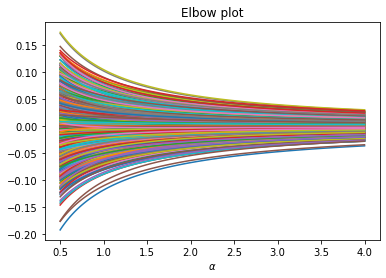

In [36]:
plt.figure()
plt.title('Elbow plot')
plt.plot(alphas, cox_m.betas)
plt.xlabel(r'$\alpha$')
plt.savefig('elbow_plot_application.png')

At this point we can also check the estimators for the order parameters

(0.5, 3.0)

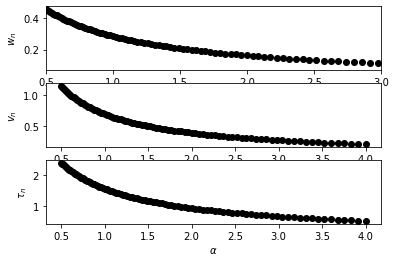

In [45]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(311)
ax2 = fig1.add_subplot(312)
ax3 = fig1.add_subplot(313)

ax1.plot(alphas, cox_m.w, 'ko')
ax1.set_ylabel(r'$w_n$')
ax1.set_xlim(left = min(alphas), right = 3.0)

ax2.plot(alphas, cox_m.v, 'ko')
ax2.set_ylabel(r'$v_n$')
ax2.set_xlim(left = min(alphas), right = 3.0)

ax3.plot(alphas, cox_m.tau, 'ko')
ax3.set_ylabel(r'$\tau_n$')
ax3.set_xlabel(r'$\alpha$')
ax3.set_xlim(left = min(alphas), right = 3.0)

We can also easily compare with the solution of the RS equations.
To do this we first need to solve the RS equations along the same regularization path. 
This is done by using an instance of the class 'rs_cox_cop', which requires the definition of the data generating process. 

In [47]:
from required_functions import rs_cox_cop
#population size for the replica symmetric equations
m = 10000
#define the instance of rs_cox_cop
cox_rs = rs_cox_cop(zeta, theta0, phi0, rho0, tau1, tau2, model, m)
#container for the data
metrics = np.empty((len(alphas), 4))
# loop over the values of lambda
for l in range(len(alphas)):
    alpha = alphas[l]
    #solve rs eqs
    cox_rs.solve(alpha)
    res = np.array([alpha, cox_rs.w, cox_rs.v, cox_rs.tau], float)
    print(res)
    metrics[l,:] = res
#convert the array into a pandas dataframe
df = pd.DataFrame(metrics, columns=['alpha', 'w', 'v', 'tau'])

[4.         0.09387627 0.21576146 0.51646088]
[3.91685839 0.09571229 0.21994609 0.52616453]
[3.83544491 0.09758117 0.22420448 0.53602721]
[3.75572364 0.09948339 0.22853765 0.54605068]
[3.67765941 0.10141942 0.23294663 0.55623669]
[3.60121778 0.10338973 0.23743247 0.56658695]
[3.52636502 0.10539482 0.24199619 0.5771032 ]
[3.4530681  0.10743514 0.24663885 0.58778712]
[3.38129469 0.1095112  0.25136149 0.5986404 ]
[3.31101312 0.11162346 0.25616515 0.60966471]
[3.24219238 0.11377242 0.2610509  0.62086169]
[3.1748021  0.11595856 0.26601977 0.63223297]
[3.10881256 0.11818237 0.27107284 0.64378013]
[3.04419464 0.12044433 0.27621116 0.65550478]
[2.98091983 0.12274494 0.28143577 0.66740844]
[2.91896021 0.12508468 0.28674774 0.67949265]
[2.85828845 0.12746403 0.29214813 0.6917589 ]
[2.79887777 0.12988349 0.29763799 0.70420865]
[2.74070197 0.13234354 0.30321838 0.71684334]
[2.68373538 0.13484466 0.30889034 0.72966437]
[2.62795285 0.13738735 0.31465493 0.74267308]
[2.5733298  0.13997209 0.32051321 

We can appreciate the behaviour of the estimator in this example.

(0.5, 3.0)

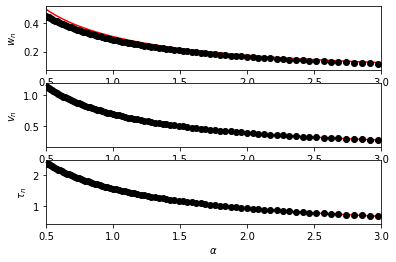

In [50]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(311)
ax2 = fig1.add_subplot(312)
ax3 = fig1.add_subplot(313)

ax1.plot(df['alpha'], df['w'], 'r-')
ax1.plot(alphas, cox_m.w, 'ko')
ax1.set_ylabel(r'$w_n$')
ax1.set_xlim(left = min(alphas), right = 3.0)

ax2.plot(df['alpha'], df['v'], 'r-')
ax2.plot(alphas, cox_m.v, 'ko')
ax2.set_ylabel(r'$v_n$')
ax2.set_xlim(left = min(alphas), right = 3.0)

ax3.plot(df['alpha'], df['tau'], 'r-')
ax3.plot(alphas, cox_m.tau, 'ko')
ax3.set_ylabel(r'$\tau_n$')
ax3.set_xlabel(r'$\alpha$')
ax3.set_xlim(left = min(alphas), right = 3.0)

We now turn to the task of estimating the signal strength. First we check the approximate cross validation loss to select a value of $\alpha$. 

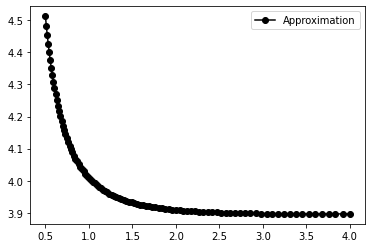

In [58]:
plt.figure()
plt.plot(alphas, cox_m.approx_loo_loss, 'k-o', label = 'Approximation')
plt.legend()


It looks like there is no minimum in the range of values of $\alpha$ considered by us. In this case the value selected will be the largest one.

We now estimate the signal strength, this is done by calling the method 'estimate_theta' and passing an array of values for $\theta_0$ where grid search is then perfomed as expalined in the reference paper.

In [51]:
vals = np.arange(0.01, 2.0, 0.01)
tic = time.time()
cox_m.estimate_theta(vals)
toc = time.time()
elapsed_time = (toc-tic)/60
print(cox_m.theta_est, theta0 )
print('elapsed time = ' + str(elapsed_time))
print('best alpha = ' + str(cox_m.alpha_best))

0.8200000000000001 1.0
elapsed time = 2.07335878610611
best alpha = 3.7557236426468252


Once $\theta$ is estimated we can de-bias the estimator $\hat{\bm{\beta}}_n$. This is done under the hood and we can access the value of the de-biased estimator $\hat{\bm{\beta}}^{(d)}_n$ as the attribute 'beta_db'. The value of $\hat{\bm{\beta}}_n$ at the value of $\alpha$ selected by approximate cross validation can be accessed as the attribute 'beta_best'.

In [59]:
beta = cox_m.beta_best
db_beta = cox_m.beta_db

We now compute the component-wise variance

In [61]:
sigma = np.zeros(p)
for j in range(p):
    Xj = X[:,j] 
    filt_col = (np.arange(0, p, 1) != j)
    Z = X[:, filt_col]
    gamma = np.linalg.inv(np.transpose(Z) @ Z) @ (np.transpose(Z) @ Xj)
    sigma[j] = np.sqrt( np.mean((Xj - Z @ gamma)**2)/ (1-zeta) )

In order to display the QQ-plot of the standardized residuals, we need the tail function of the Gaussian distribution.

In [62]:
from scipy.special import erf 

def Q(x):
    return 0.5 + 0.5*erf(x/np.sqrt(2))

We now compute the residuals, their variance and compute their empirical and theoretical quantiles 

In [63]:
std_db_res = cox_m.v_db / (sigma * np.sqrt(p))
db_residuals = (db_beta - beta0) / std_db_res
ord_res_db = np.sort(db_residuals)
emp_quants = np.arange(1, len(ord_res_db) + 1, 1) / len(ord_res_db)
theo_quants_db = [Q(ord_res_db[j]) for j in range(len(ord_res_db))]

Text(0, 0.5, 'theoretical quantiles')

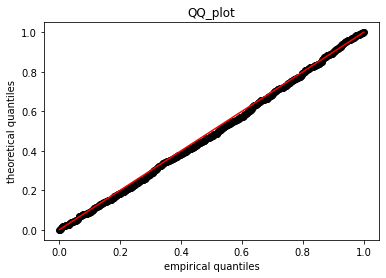

In [64]:
plt.figure()
plt.title('QQ_plot')
plt.plot(emp_quants, theo_quants_db, 'ko', label = 'de-biased')
plt.plot(emp_quants, emp_quants, 'r-')
plt.xlabel('empirical quantiles')
plt.ylabel('theoretical quantiles')

The QQ-plot above shows convincingly that the resulting estimator is unbiased, as the residuals have a distribution matching the one of a standard gaussian random variable. Of course we can also check with a scatter plot.

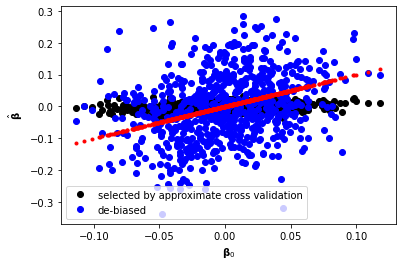

In [65]:
plt.figure()
plt.plot(beta0, beta, 'ko', label = 'selected by approximate cross validation')
plt.plot(beta0, db_beta, 'bo', label = 'de-biased')
plt.plot(beta0, beta0, 'r.')
plt.xlabel(r'$\mathbf{\beta}_0$')
plt.ylabel(r'$\hat{\mathbf{\beta}}$')
plt.legend()

Finally we compare the de-biased estimator for the Cumulative Hazard with the "classical" Nelson -Aalen estimator at the value of $\alpha$ selected by approximate cross validation.

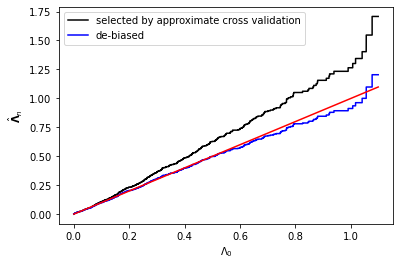

In [56]:
plt.figure()
cox_m.fit_frailty(cox_m.theta_est)
plt.plot(GM.ch(cox_m.t), cox_m.H, 'k-', ds = 'steps-post', label = 'selected by approximate cross validation')
plt.plot(GM.ch(cox_m.t), cox_m.H_frailty, 'b-', ds = 'steps-post', label = 'de-biased')
plt.plot(GM.ch(cox_m.t), GM.ch(cox_m.t), 'r-')
plt.xlabel(r'$\Lambda_0$')
plt.ylabel(r'$\hat{\mathbf{\Lambda}}_n$')
plt.legend()

The effect of the de-biasing procedure is evident : the inferred value of $\hat{\Lambda}_n$ in black is way larger than the de-biased one in blue, which is very close to the theoretical line in red which indicates perfect recovery of the true Cumulative Hazard $\Lambda_0$. 